In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
from scipy.fft import fft, fftfreq
from scipy import signal

In [2]:
def FIRrespt(ninput,xinput,nh,h):
    Nx=len(xinput);Nh=len(h);conv=np.convolve(xinput,h);n0=ninput[0]+nh[0];Nconv=Nx+Nh-1;nconv=np.arange(n0,n0 + Nconv);
    R = np.vstack((nconv,conv)).T
    return R   

In [3]:
def FIRrespf(w,h):
    Nh=len(h); H = 0
    for i in np.arange(Nh):
        H = H + h[i]*np.exp(-1j*w*i)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R 

In [4]:
def IIRrespt(xinput,c,d):
    N1 = len(xinput) # 
    nx = np.arange(-(len(c)-1),N1)
    x = xinput
    for k in np.arange(len(c)-1):
        x = np.insert(x,0,0)
    ny = np.arange(-(len(d)-1),N1)
    y = np.arange(0,len(ny),dtype=np.float64)
    for k in np.arange(len(d)-1):
        y[k] = 0
    for i in np.arange(len(d)-1,len(y)):
        z = 0
        for j in np.arange(1,len(d)):
            z = z - d[j]*y[i-j] + c[j]*x[i-j]
        y[i] = (z + c[0]* x[i])/d[0]
    R = np.vstack((ny,y)).T
    return R

In [5]:
def IIRrespf(w,c,d):
    Nc=len(c); Nd=len(d); Hnum = 0; Hden = 0
    for i in np.arange(Nc):
        Hnum = Hnum + c[i]*np.exp(-1j*w*i)
    for i in np.arange(Nd):
        Hden = Hden + d[i]*np.exp(-1j*w*i)
    H = np.divide(Hnum,Hden)
    R = np.vstack((w,abs(H),np.angle(H))).T
    return R

In [20]:
def FPM(nombreArchivo):
    ECG = bioread.read_file (nombreArchivo)
    canales = ECG.channels
    for i in np.arange (0,len(canales)):
        print (f"Canal {i}: {canales[i]}")

    canal_elegido = int (input ("Ingrese el canal que desea analizar:"))

    señal = ECG.channels[canal_elegido].data
    N = len(señal) ; n = np.arange (N)
    
    M = np.array ([3,5,10,15,20]) #vector de ordenes de los FPM
    k = np.arange (0,30,dtype=np.float64)
    resp = np.empty ((N,len(M)))
    for i,N1 in enumerate (M):
        FPM = np.piecewise (k,(0<=k)&(k<=N1-1),[1/N1,0])
        resp[:,i] = np.convolve (señal,FPM,"same")

    plt.figure(figsize=(20,30))
    for i,j in enumerate (M):
        plt.subplot (5,2,j)
        plt.plot(n,señal,color="y")
        plt.plot(n, resp[:,i],color="k")
        plt.text (900,0.55,s="orden=")
        plt.text (1060,0.55,s=j)
    plt.show()


Canal 0: Channel ECG (.05 - 150 Hz): 20167 samples, 1000.0 samples/sec, loaded: True


ValueError: num must be 1 <= num <= 10, not 15

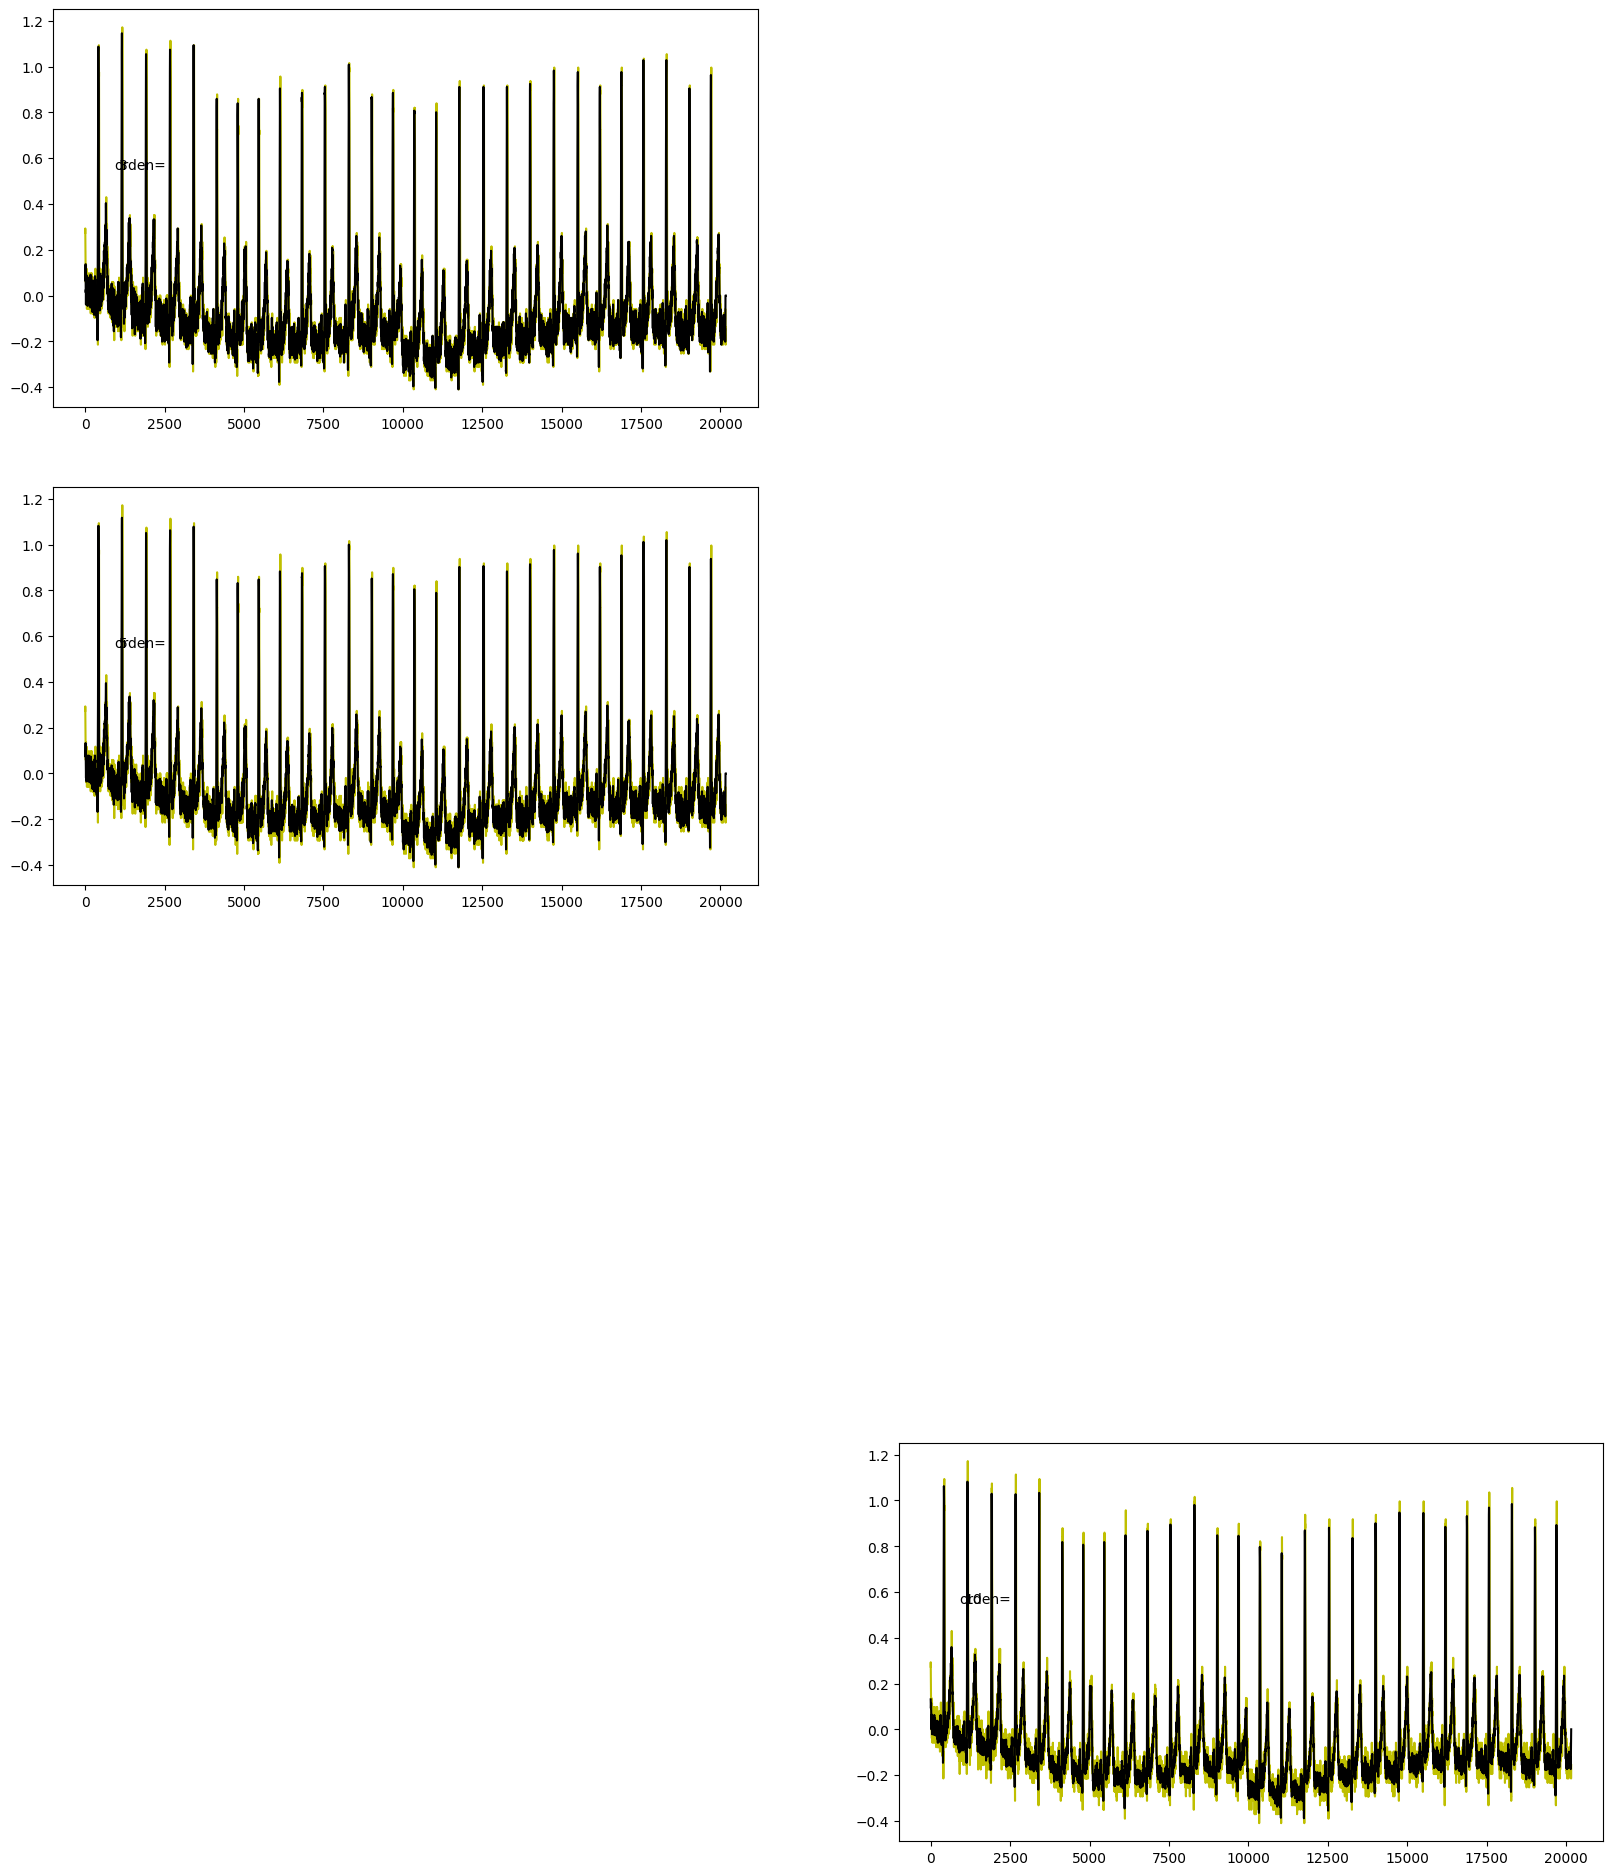

In [21]:
FPM ("/Users/paulaaguirrecarol/Desktop/PDSB 1/2. ecg_sinf.acq")